# Compare human hippo AD vs WT

In [1]:
suppressPackageStartupMessages({
    library(Seurat)
    library(SeuratWrappers)
    library(patchwork)
    library(ggplot2)
    library(repr)
    library(gridExtra)
    library(edgeR)
    library(SingleCellExperiment)
    library(Matrix)
    library(scran)
    library(tidyverse)
    library(ggrepel)
    library(scater)
})
options(future.globals.maxSize = 1e9)
options(Seurat.object.assay.version = "v5")
options(ggrepel.max.overlaps = Inf)

In [2]:
setwd("~/5XFAD_mouse/data/")

In [3]:
seurat_object <- readRDS(
    "humanAD_RNA_seurat_object.rds")

In [6]:
human_object <- subset(seurat_object, subset = group %in% c("AD", "Normal"))
human_object <- human_object[!grepl("^RP[SL][[:digit:]]|^RPLP[[:digit:]]|^RPSA", rownames(human_object)), ]
human_object <- human_object[!grepl("^MT-", rownames(human_object)), ]

[1] "Oligo"


Removing 3915 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



[1] "OPC"


Removing 7150 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



[1] "Micro"


Removing 9212 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



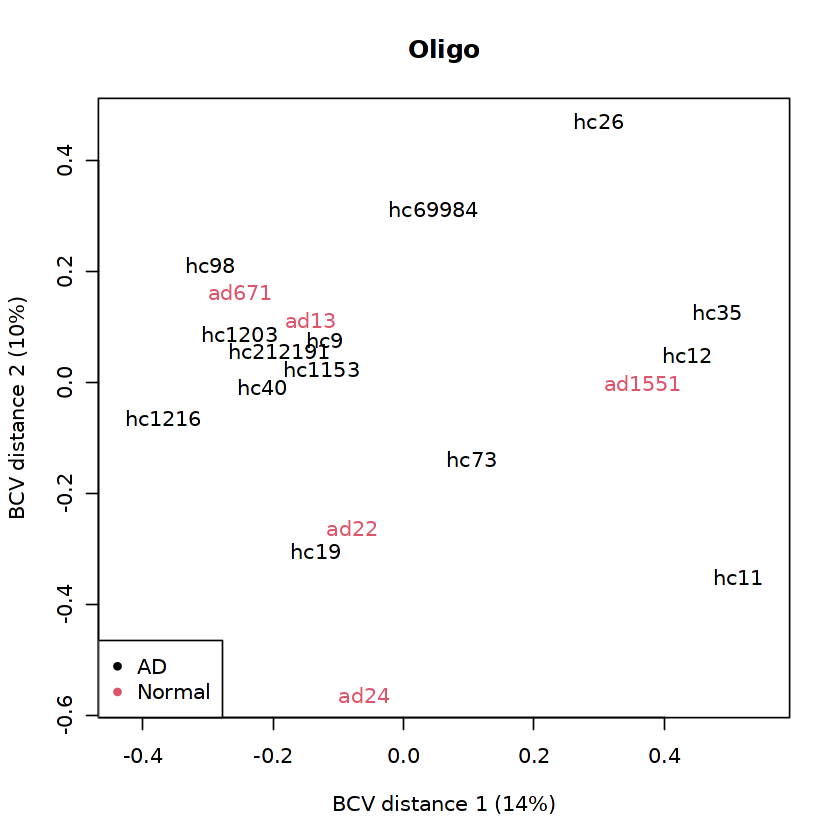

[1] "Astro"


Removing 6779 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



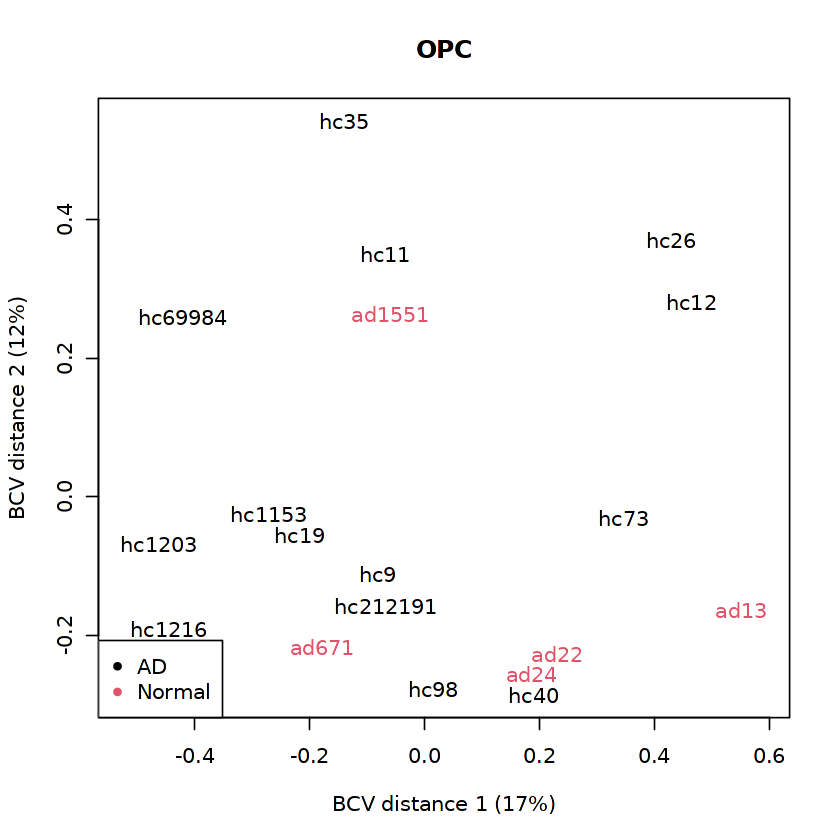

[1] "DG"


Removing 11585 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



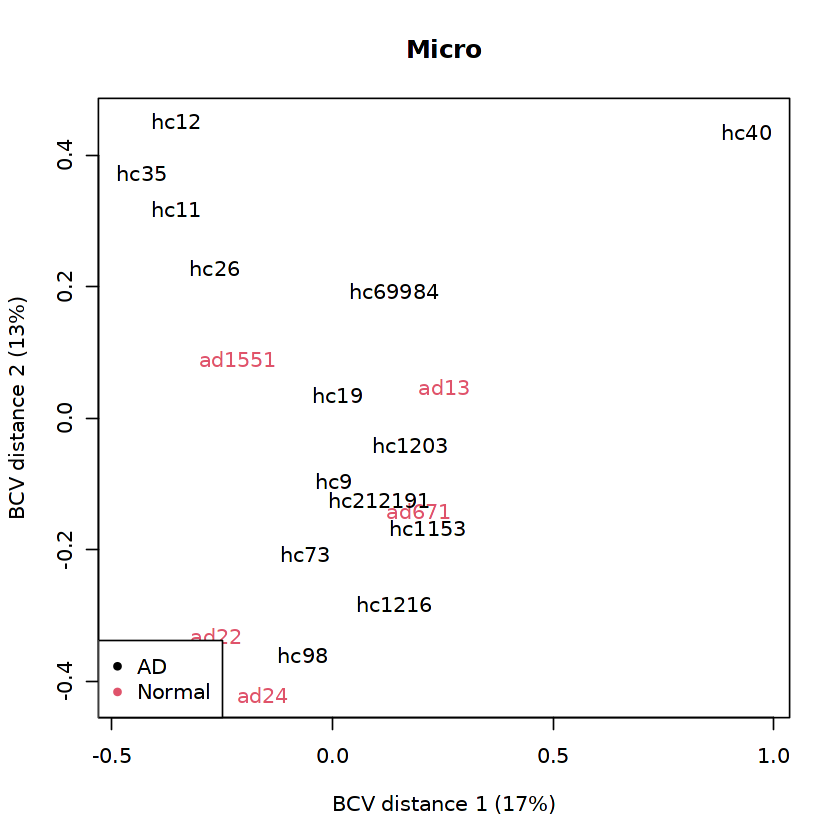

[1] "PVALB"


Removing 8274 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



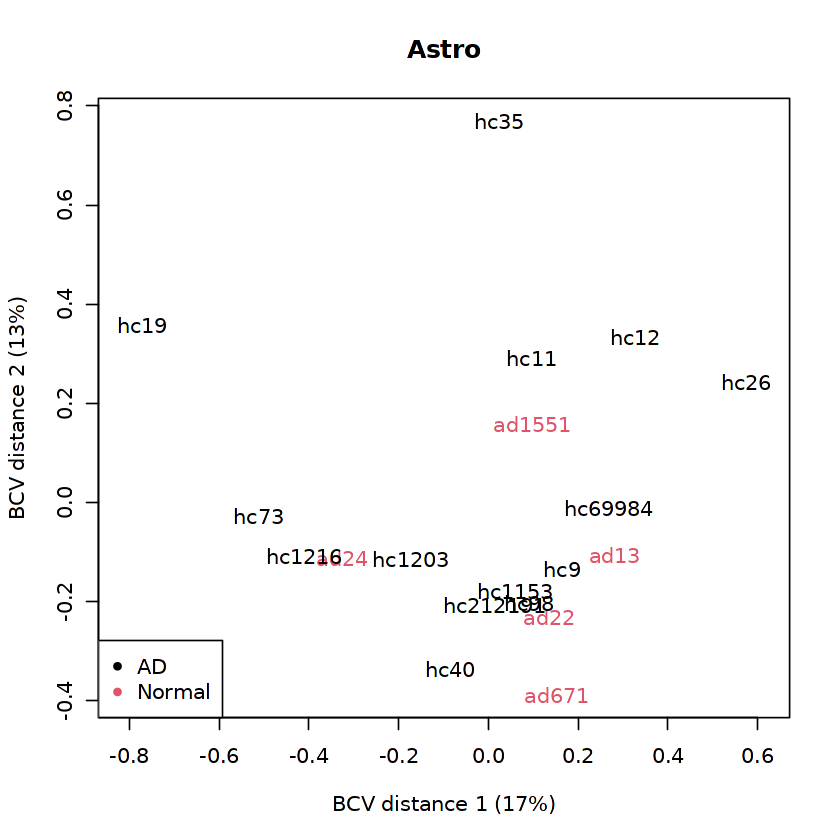

[1] "VIP"


Removing 7597 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



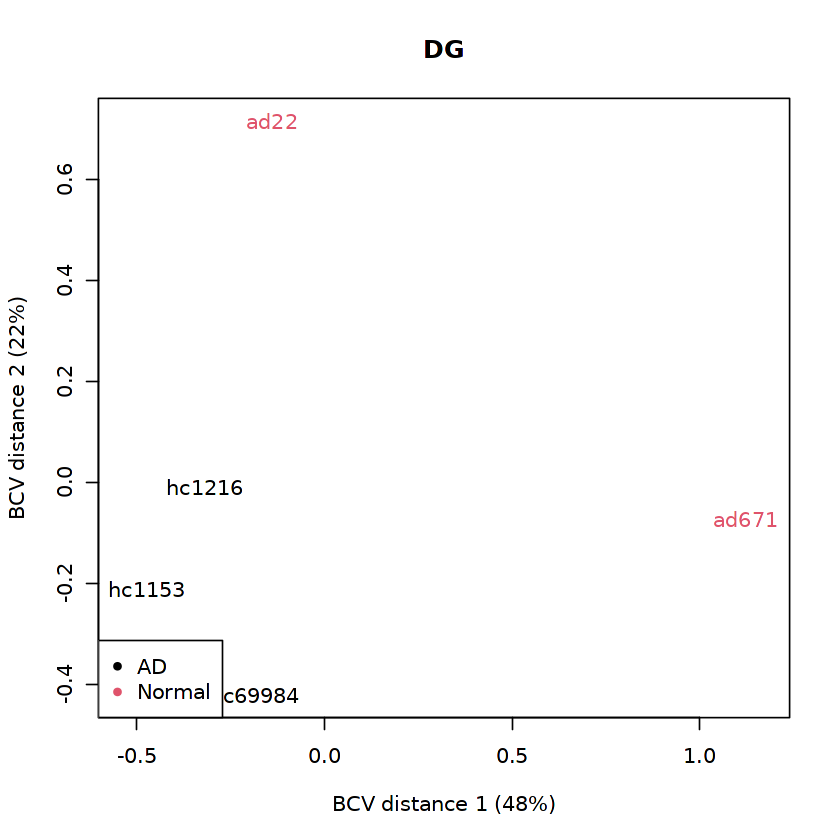

[1] "SUB"


Removing 3923 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



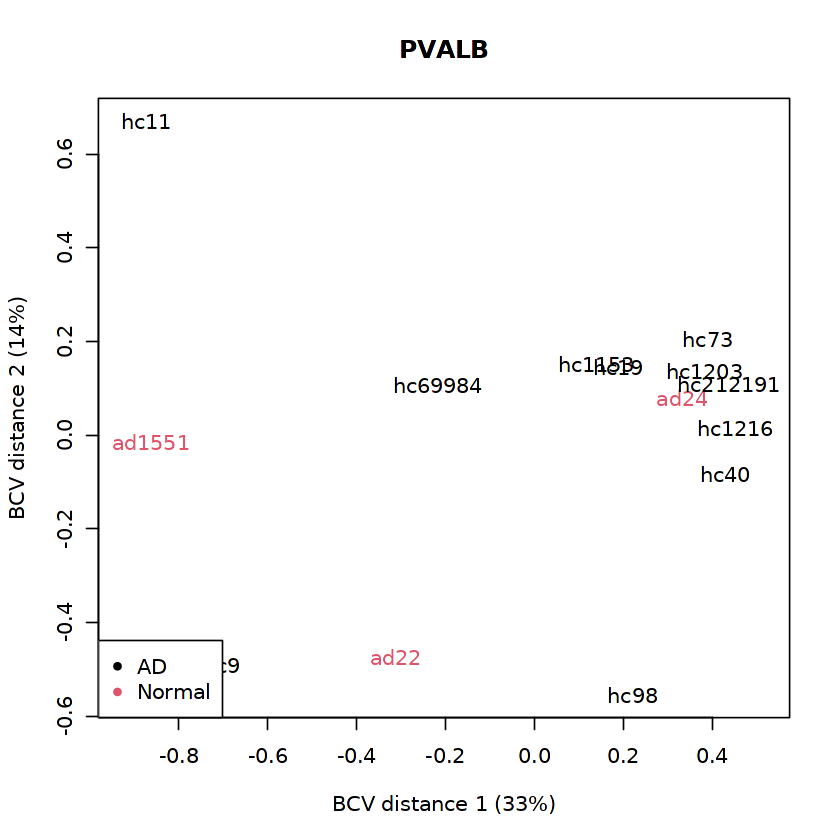

[1] "SST"


Removing 9966 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



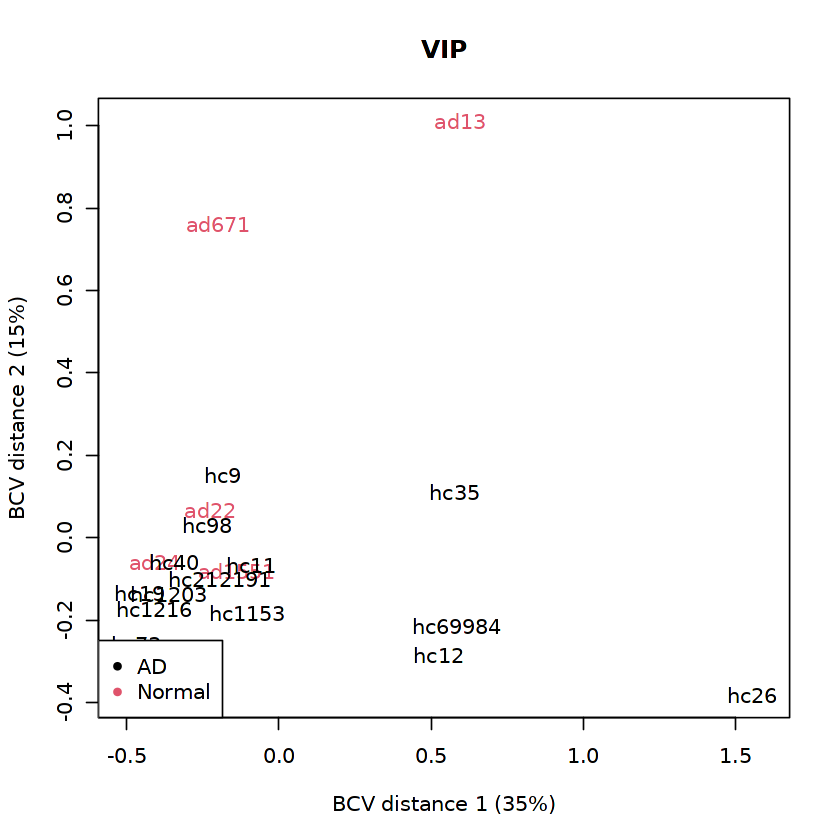

[1] "Macro"


Removing 18579 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



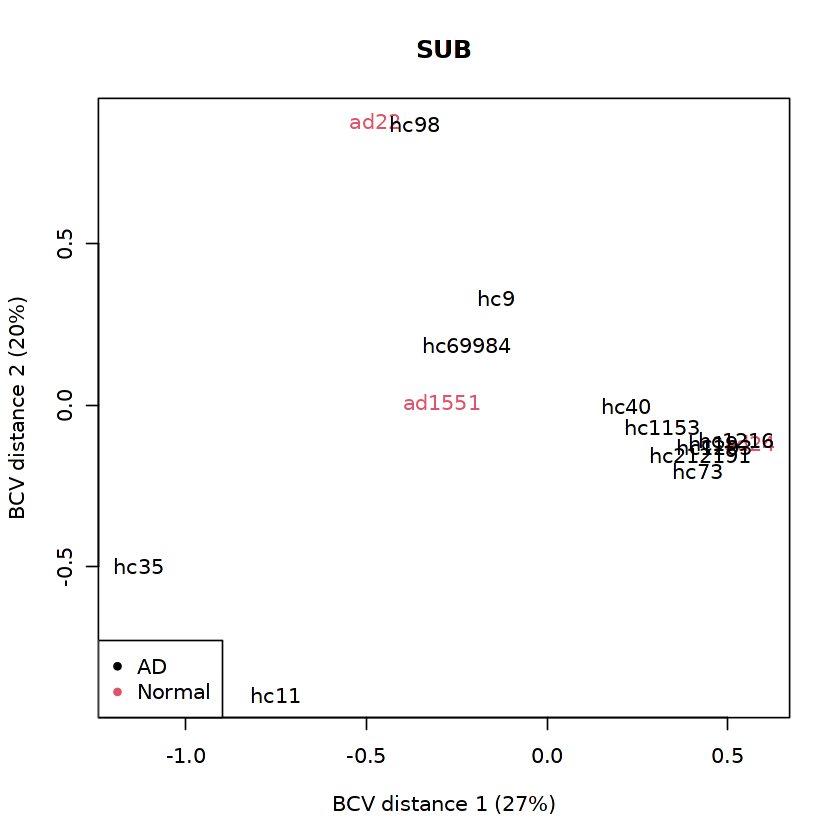

[1] "LAMP5"


Removing 9738 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



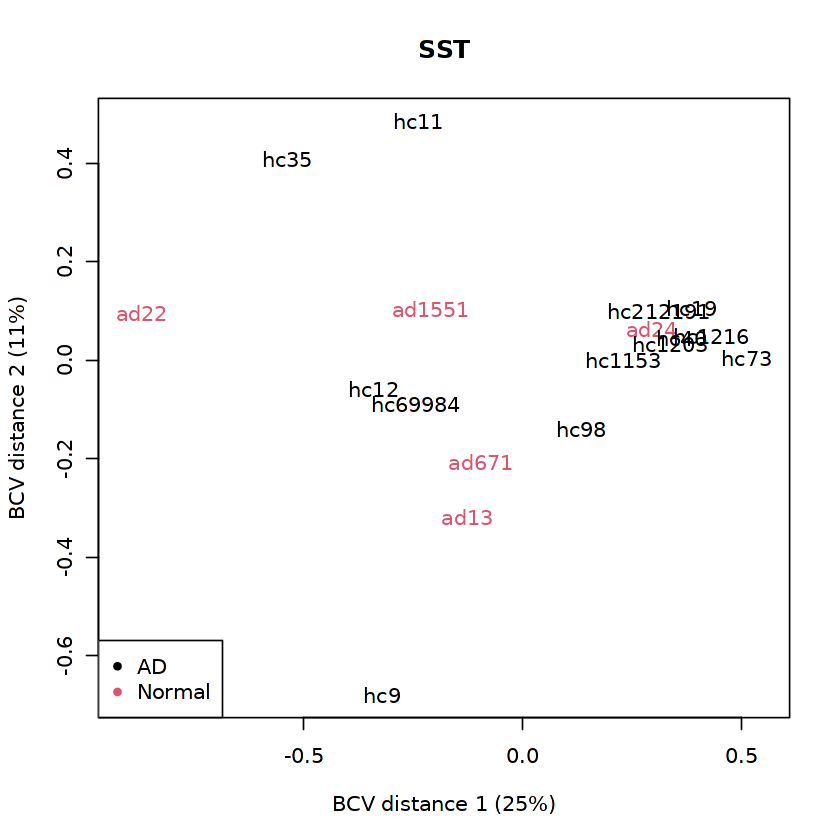

[1] "NR2F2"


Removing 9543 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



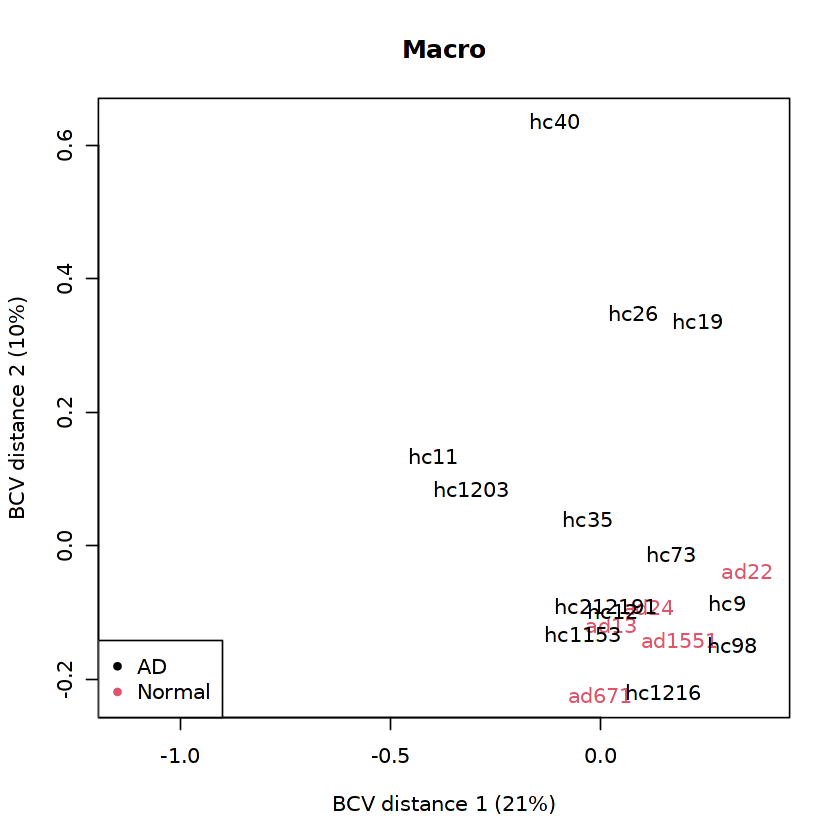

[1] "CA"


Removing 9011 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



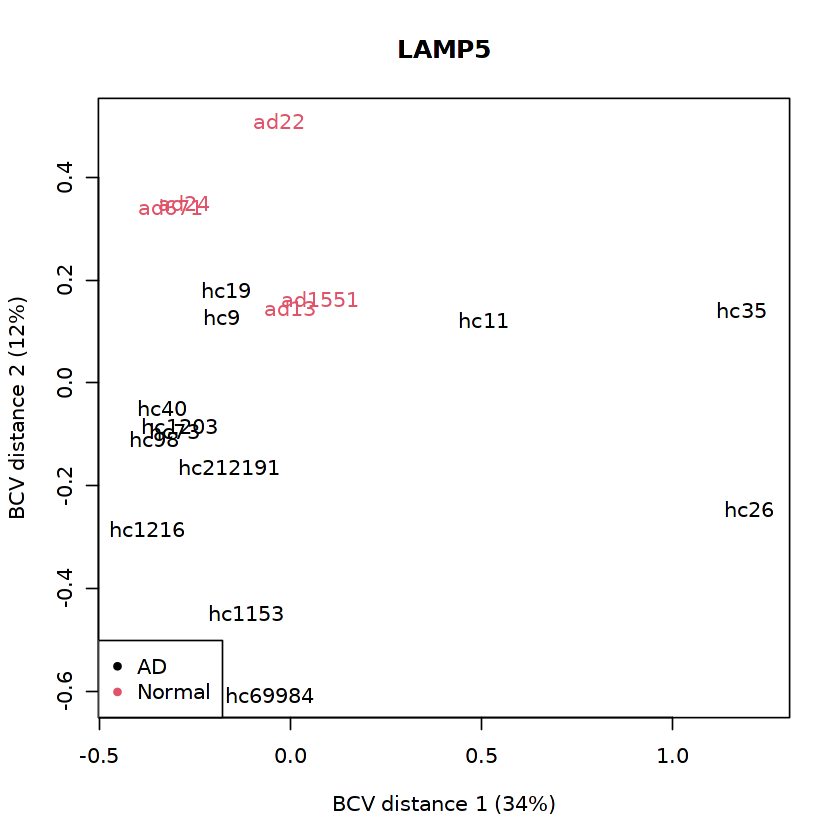

[1] "Endo_VLMC"


Removing 18683 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



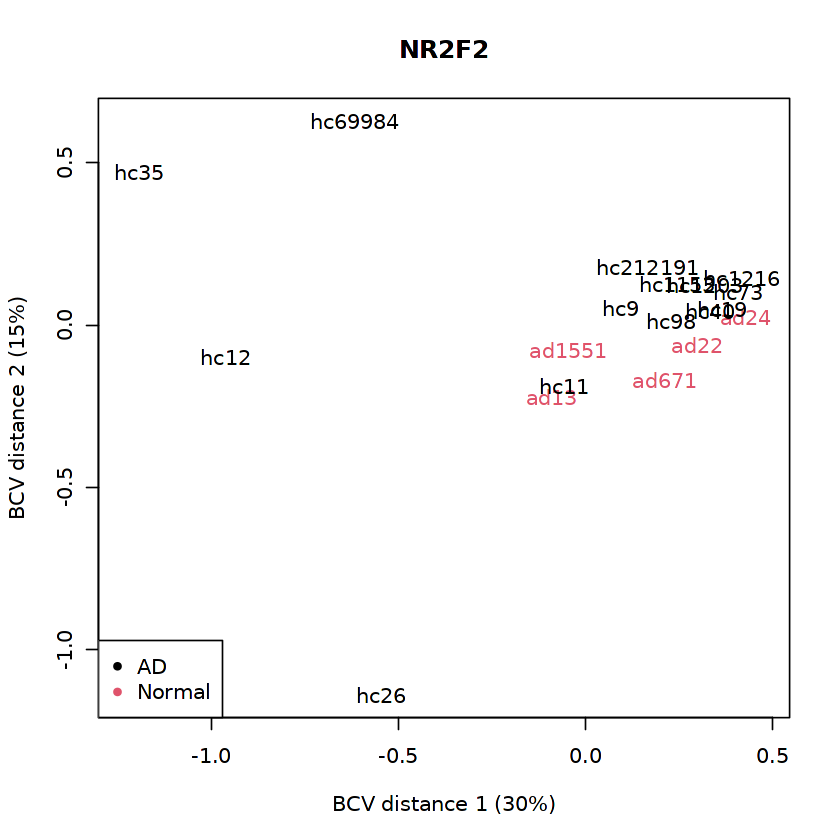

[1] "Chandelier"


Removing 14329 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



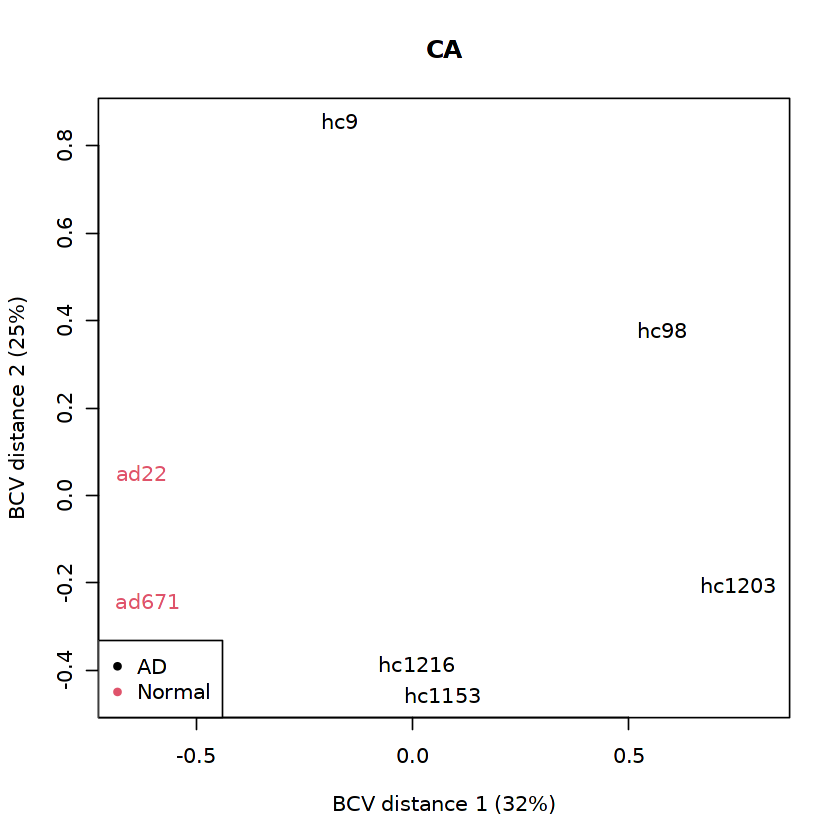

[1] "T-Cell"


Removing 21396 rows with all zero counts

Note: the bcv method is now scheduled to be removed in a future release of edgeR.



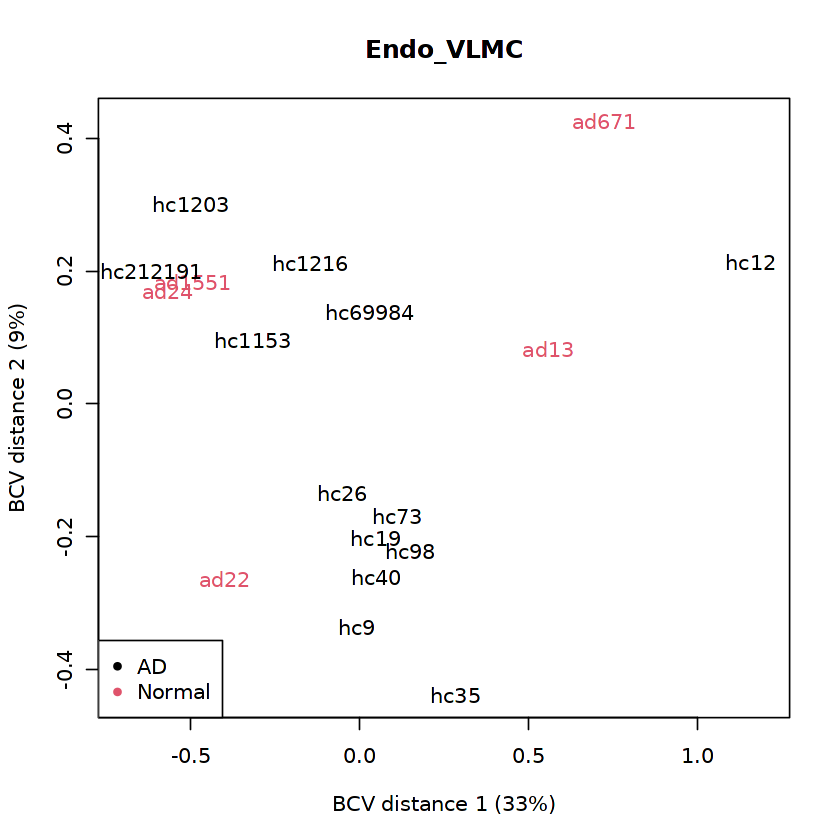

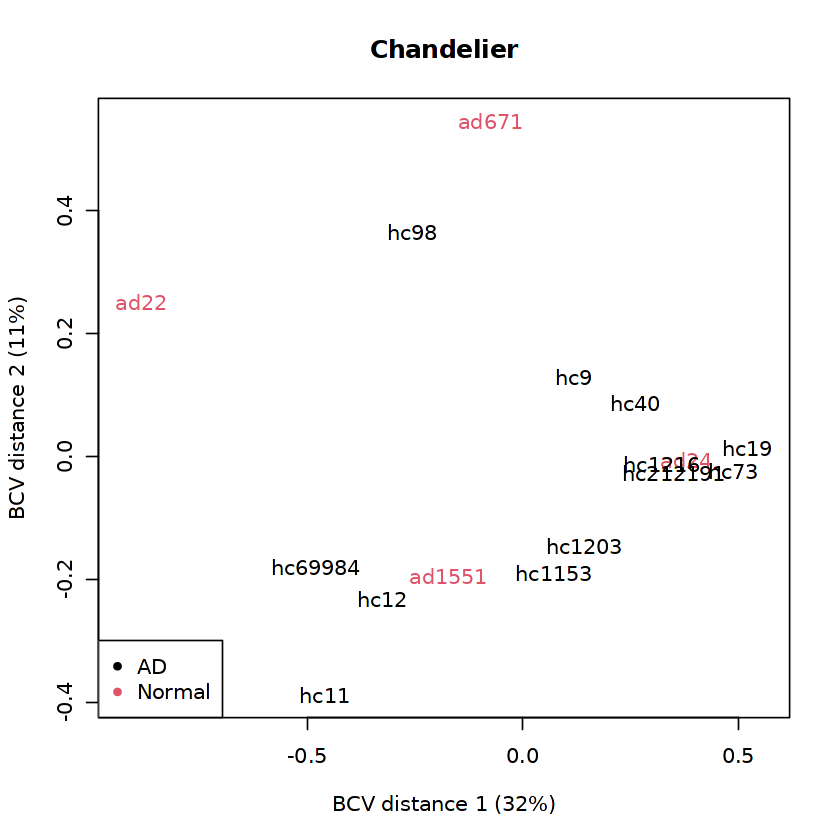

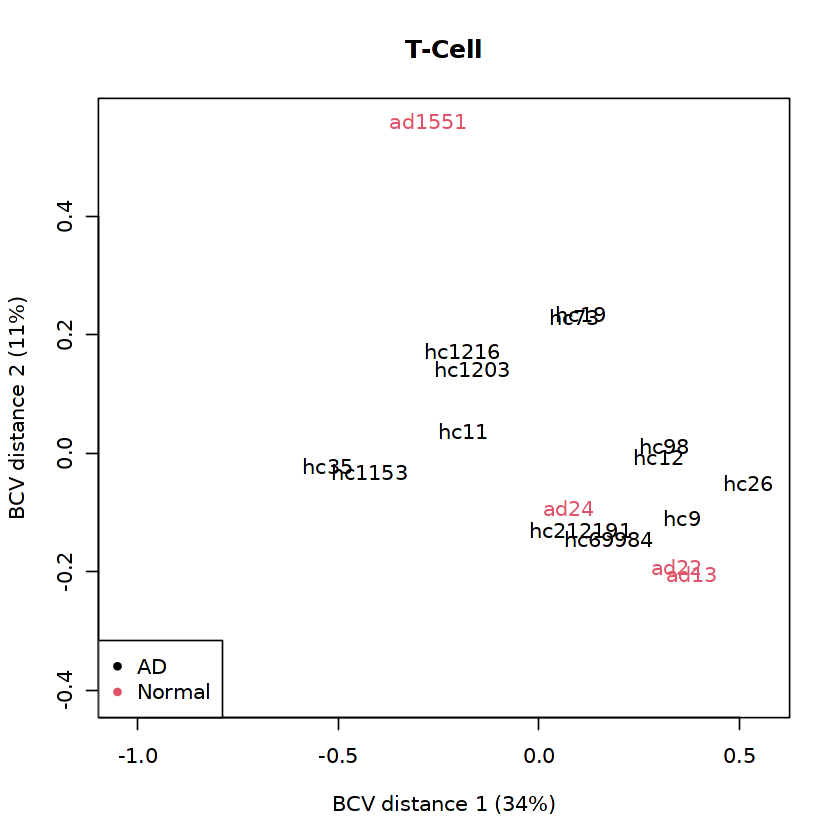

In [7]:
for (cluster in unique(human_object$final_celltype)) {
    suppressPackageStartupMessages({
        library(scran)
        library(scater)
    })
    print(cluster)
    flush.console()
    curr_object <- human_object[, human_object$final_celltype == cluster]
    if (ncol(curr_object) < 10) {
        next
    }
    curr_counts <- LayerData(curr_object, layer = c("counts"))
    curr_meta <- curr_object@meta.data
    curr_sce <- SingleCellExperiment(assays = list(counts = curr_counts), colData = curr_meta)
    curr_sce$group <- factor(curr_sce$group, levels = c("Normal", "AD"))
    groups <- curr_sce$donor
    if (length(unique(groups)) < 2) {
        next
    }
    curr_aggr <- aggregateAcrossCells(curr_sce, groups, store.number = "group.size")
    
    curr_dge <- DGEList(counts = counts(curr_aggr), group = curr_aggr$group, remove.zeros = TRUE)
    keep <- filterByExpr(curr_dge, min.count = 5, min.prop = 0.5)
    curr_dge <- curr_dge[keep, , keep.lib.sizes=FALSE]
    curr_dge <- calcNormFactors(curr_dge, method = "TMM")
    
    detach("package:scran", unload = TRUE)
    detach("package:scater", unload = TRUE)
    plotMDS(curr_dge, method="bcv", col=as.numeric(curr_dge$samples$group))
    legend("bottomleft", as.character(unique(curr_dge$samples$group)), col=1:2, pch=20)
    title(main = cluster)
    
    curr_design <- model.matrix(~ 0 + curr_aggr$group)
    colnames(curr_design) <- levels(curr_aggr$group)
    curr_dge <- estimateDisp(curr_dge, curr_design, robust = TRUE)
    curr_fit <- glmQLFit(curr_dge, curr_design)
    curr_glf <- glmQLFTest(curr_fit, contrast = c(-1, 1))
    
    write.table(
        topTags(curr_glf, n = Inf)$table, 
        file.path("DGE_humanAD/", paste0(cluster, ".result.tsv")), 
        row.names = TRUE,
        col.names = TRUE,
        quote = FALSE,
        sep = "\t"
    )
}